In [1]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [2]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

**Задание 1.1:** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        
        return np.square(X.dot(w) - y).mean()

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        
        l = X.shape[0]
        
        return 2 * np.transpose(X).dot(X.dot(w) - y) / l

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [4]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2:** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [5]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    w_history = list()
    w_current = w_init
    
    for i in range(n_iterations):
        w_current = w_current - lr * loss.calc_grad(X, y, w_current)
        
        w_history.append(w_current)
        
    return w_history
        
        
        

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.2625821435192
0.8670644395649493


In [8]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3:** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

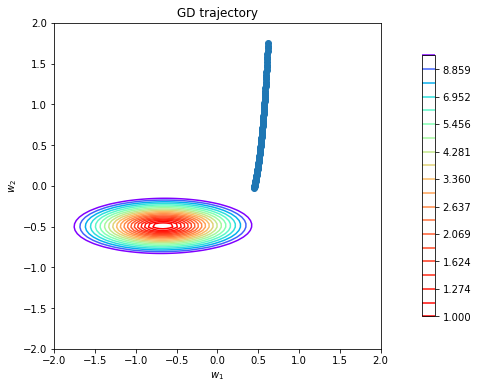

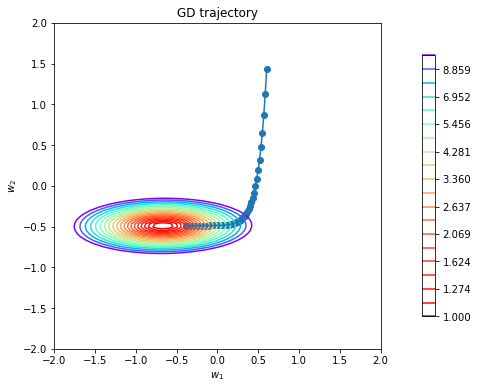

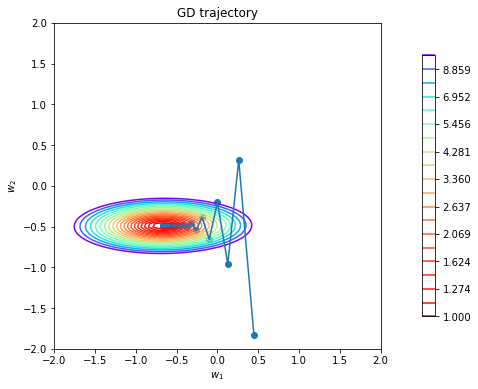

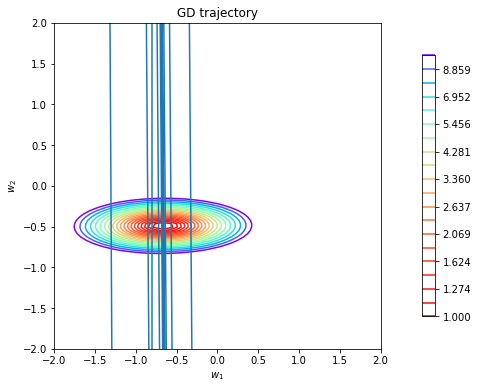

In [9]:
lr_list = [0.0001, 0.001, 0.01, 0.1]

for lr in lr_list:
    w_list = gradient_descent(w_init, X, y, loss, lr, 100)
    
    plot_gd(w_list, X, y, loss=loss)


# по графикам видно что оптимальным значением будет 0.01
# слишком маленькая длина шага приводит к тому, что за 100 шагов градиент не сходится,
# хотя стоит отметить, что траектория менее хоатичная, чем в случае с lr = 0.01
# слишком большая длина шага ведёт к тому, что градиентный спуск вообще не уменьшает ошибку
# и его очень сильно "колбасит"
    


Теперь реализуем стохастический градиентный спуск

**Задание 1.4:** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    w_history = list()
    w_current = w_init
    
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        
        batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        w_current = w_current - lr * loss.calc_grad(batch, y_batch, w_current)
        
        w_history.append(w_current)
        
    return w_history

**Задание 1.5:** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

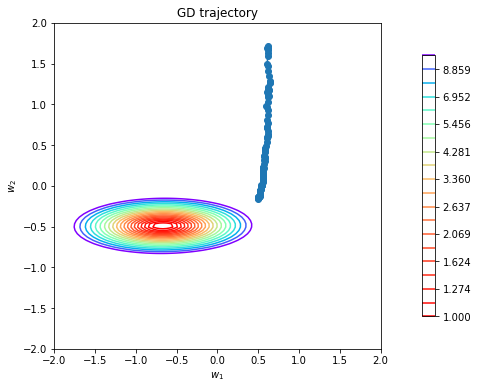

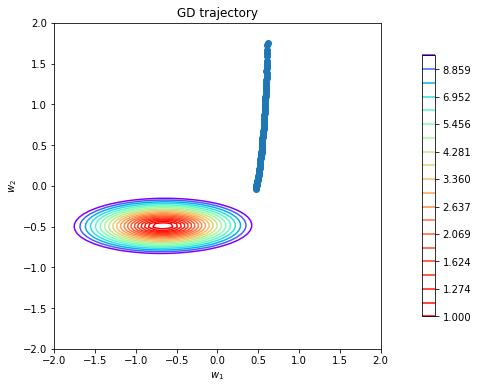

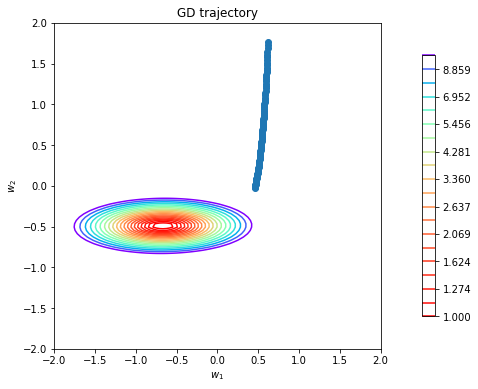

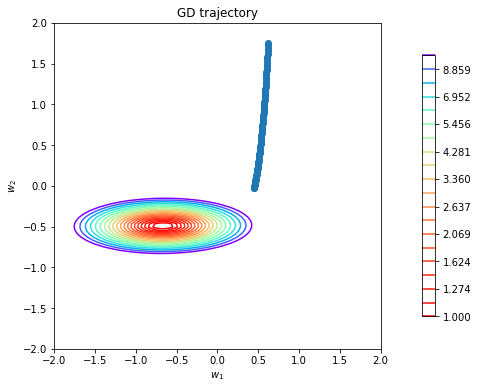

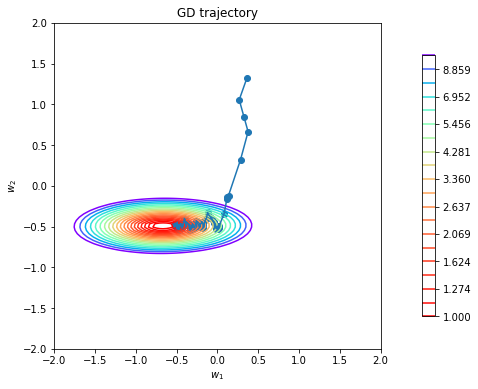

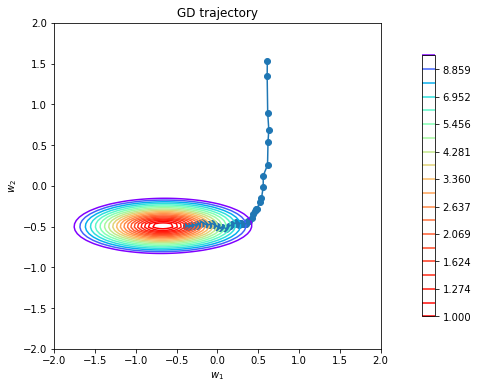

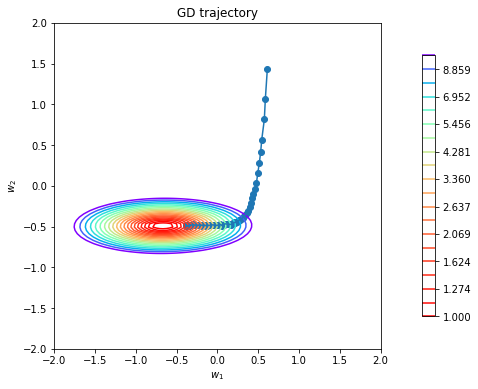

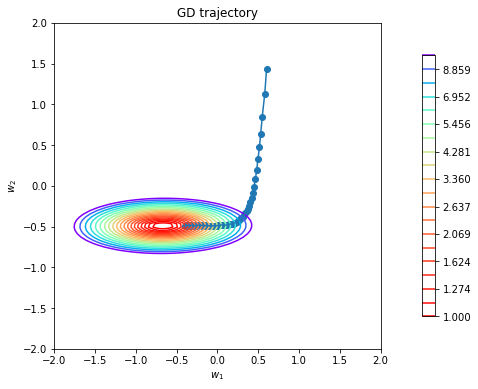

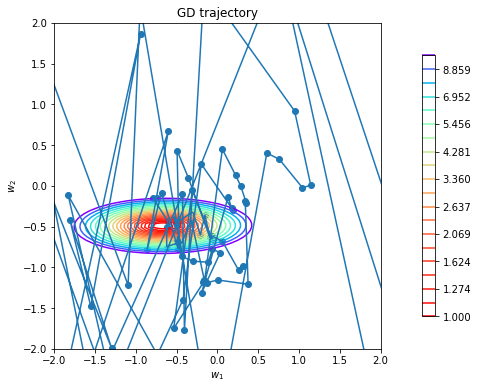

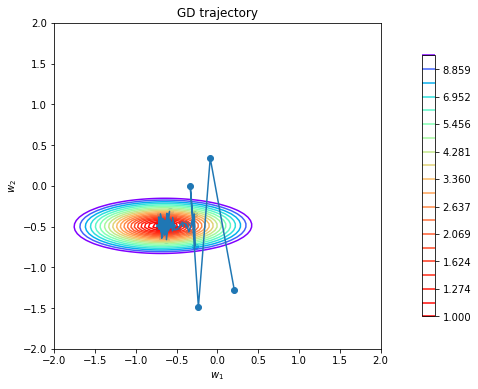

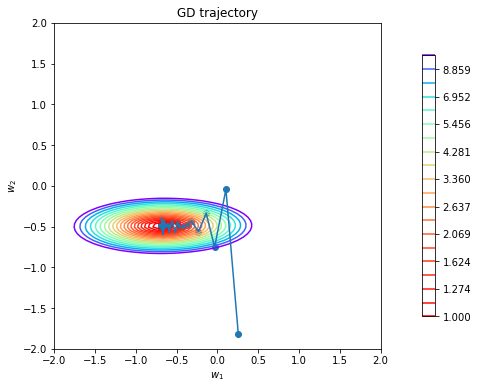

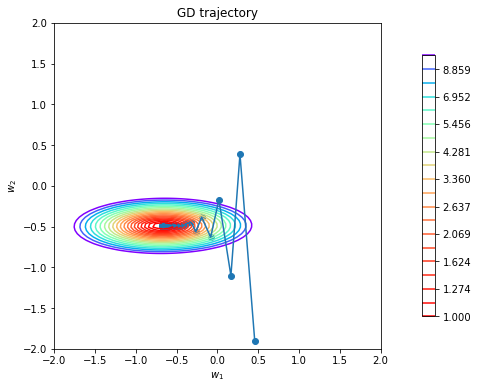

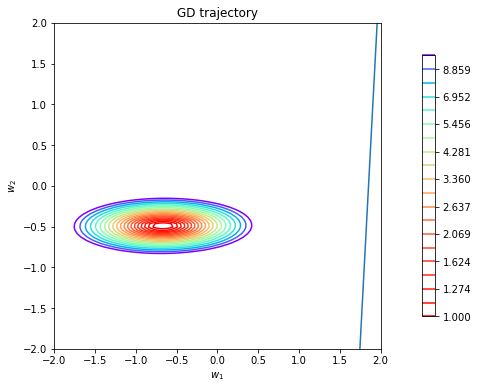

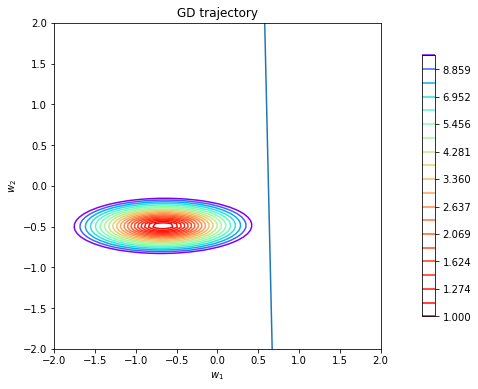

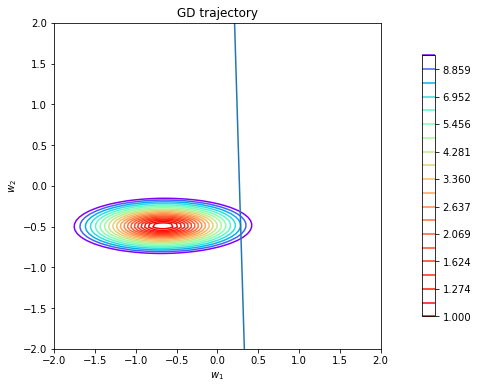

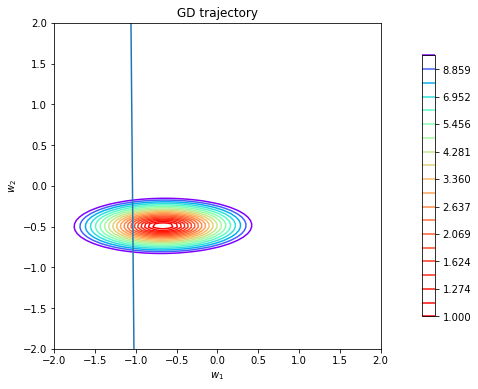

In [11]:
np.random.seed(1337)

batch_list = [1, 10, 55, 150]

for lr in lr_list:
    for batch in batch_list:
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch, 100)
    
        plot_gd(w_list, X, y, loss)

# видно что при адекватных значениях lr, стохастический градиентный спуск неплохо сходится
# проблема в том, что чем меньше batch, тем более хоатично движение к минимуму ошибки
# однако премущество состоит в скорости работы этого метода, вложенный цикл отработал очень быстро
# траектории обычного градиентного спуска более плавные

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6:** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    w_history = list()
    w_current = w_init
    
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        
        batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        w_current = w_current - lr * (1 / (1 + i))**p * loss.calc_grad(batch, y_batch, w_current)
        
        w_history.append(w_current)
        
    return w_history

**Задание 1.7:** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

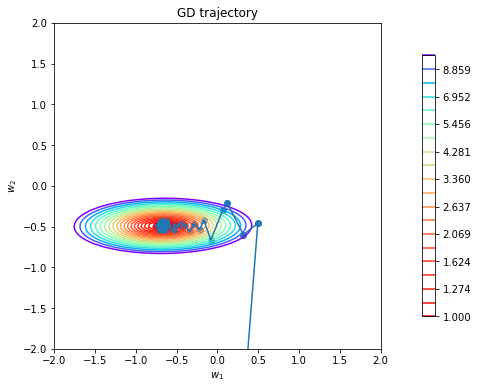

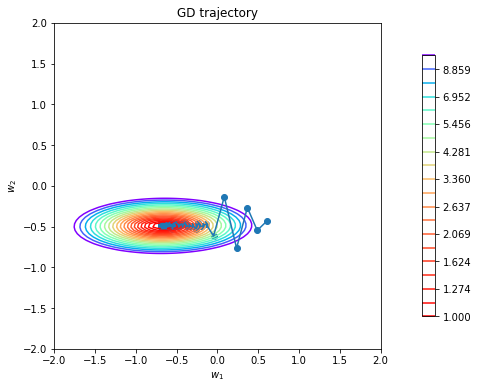

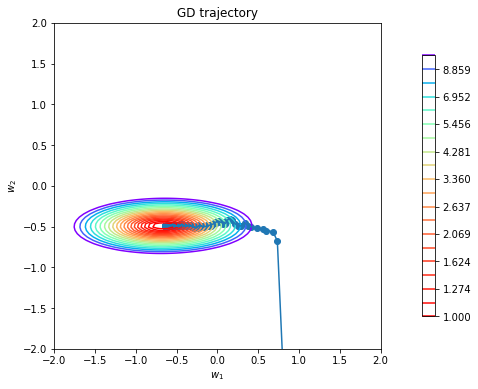

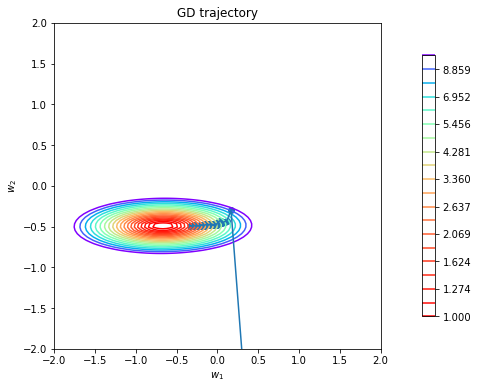

In [13]:
np.random.seed(1337)

p_list = [0.1, 0.33, 0.66, 1]

for p in p_list:
    w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, p, 1000)
    
    plot_gd(w_list, X, y, loss=loss)

# параметр p сглаживает тракеторию, чем он больше, тем менее хаотичные траектории

**Задание 1.8:** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

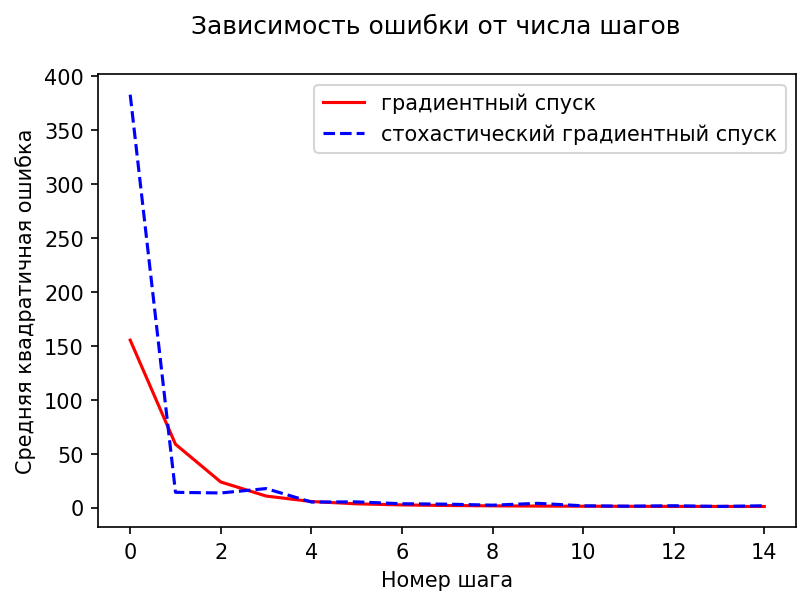

In [14]:
np.random.seed(1337)

w_gd = gradient_descent(w_init, X, y, loss, 0.01, 15)
w_sgd = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0, 15)

find_loss = lambda w: loss.calc_loss(X, y, w)

gd_losses = list(map(find_loss, w_gd))
sgd_losses = list(map(find_loss, w_sgd))
iterations = list(range(15))


fig, ax = plt.subplots(1, 1, dpi=150)

ax.plot(iterations, gd_losses, color='red', label='градиентный спуск')
ax.plot(iterations, sgd_losses, linestyle='--', color='blue', label='стохастический градиентный спуск')

fig.suptitle('Зависимость ошибки от числа шагов')
ax.legend()
ax.set_xlabel('Номер шага')
ax.set_ylabel('Средняя квадратичная ошибка')

plt.show()

# на таком графике нельзя отобразить приемущество sgd, так как его приемущество в скорости вычисления
# у меня случайно получилось что sgd сходится за меньшее число итераций чем просто gd,
# в общем случае это не так
# опять же видно, что gd сходится плавно, а sgd скачками, и в какой-то момент даже уходит из 0 ошибки

## Часть 2. Линейная регрессия

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1:** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [15]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        

        w_init = np.random.uniform(-10, 10, (X.shape[1]))

        self.w = gradient_descent(w_init, X, y, self.loss, self.lr, 100000)[-1]
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X.dot(self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [16]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [17]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)

X_raw = X_raw[~X_raw[25].isna()].reset_index()
X_raw.head()

,index,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [18]:
y_ = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Задание 2.2:** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Заполните пропуски
* Разделите датасет на обучающую и тестовую выборку
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

np.random.seed(1937)

X_raw.drop(columns=['index'], inplace=True)


# разделяем признаки на числовые и категориальные
numeric_columns = X_raw.columns[X_raw.dtypes != 'object']
object_columns = X_raw.columns[X_raw.dtypes == 'object']


# заполняем пропуски числовых признаков средним и стандартизируем их
X_numeric = X_raw[numeric_columns]
X_numeric = X_numeric.fillna(X_numeric.mean())


# у категориальных заполняем пропуски строкой 'no_information' (это тоже может быть отдельной категорией)
X_obj = X_raw[object_columns]
X_obj = X_obj.fillna('no_information')


# соединяем в один датасет, пропуски обработаны
X_filled = np.hstack([X_numeric, X_obj])


# разделим датасет на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X_filled, y_, random_state=1, test_size=0.25)


# нормализуем числовые признаки и кодируем категориальные с помощью дамми кодирования
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_filled[:, 15: ])

scaler = StandardScaler()

X_train_numeric = scaler.fit_transform(X_train[:, :15])
X_train_dum = pd.DataFrame(encoder.transform(X_train[:, 15: ]))

X_test_numeric = scaler.transform(X_test[:, :15])
X_test_dum = encoder.transform(X_test[:, 15: ])


# соединяем в итоговую тренировочную и тестовую выборку
X_train = np.hstack([X_train_numeric, X_train_dum])
X_test = np.hstack([X_test_numeric, X_test_dum])

**Задание 2.3:** Обучите написанную вами линейную регрессию на обучающей выборке

In [20]:
linear_regression = linear_regression.fit(X_train, y_train)

**Задание 2.4:** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [21]:
from sklearn.metrics import mean_squared_error

print(f'Train MSE: {mean_squared_error(y_train, linear_regression.predict(X_train))}')
print(f'Test MSE: {mean_squared_error(y_test, linear_regression.predict(X_test))}')


Train MSE: 1757806.8710623619
Test MSE: 8080772.349884835


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5:** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [22]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        
        return np.square(X.dot(w) - y).mean() + self.coef * np.square(w[:-1]).sum()
        # Вычислите значение функции потерь при помощи X, y и w и верните его

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        
        l = X.shape[0]
        
        w[-1] = 0

        return 2 * np.transpose(X).dot(X.dot(w) - y) / l + 2 * self.coef * w
        # Вычислите значение вектора градиента при помощи X, y и w и верните его

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [23]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6:** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [24]:
reg_coefs = np.linspace(0.001, 1, 20)

models = []

for reg_coef in reg_coefs:

    model = LinearRegression(MSEL2Loss(reg_coef))
    
    models.append(model.fit(X_train, y_train))
    

best_model = min(models, key=lambda model: mean_squared_error(y_test, model.predict(X_test)))

print(f'Наилучший коэффициент регуляризации: {best_model.loss.coef}')
print(f'Train MSE: {mean_squared_error(y_train, best_model.predict(X_train))}')
print(f'Test MSE: {mean_squared_error(y_test, best_model.predict(X_test))}')

# видно что ошибка и на трэйне и на тесте уменьшилась
# обощающая способность модели улучшилась

Наилучший коэффициент регуляризации: 0.001
Train MSE: 2050267.4359003992
Test MSE: 6031667.074642258


В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7:** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [25]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        
        errors = X.dot(w) - y # отклонения прогноза от правильного ответа для каждого объекта
        
        h_func = lambda z: 0.5 * z**2 if abs(z) < self.eps else self.eps * (abs(z) - 0.5 * self.eps) # определяем функции Хубера
        
        h_losses = np.array(list(map(h_func, errors))) # к каждому отклонению применяем функцию Хубера

        loss = h_losses.mean() # ситаем среднюю ошибку
        
        return loss
        
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        
        errors = X.dot(w) - y
        
        h_derivative = lambda z: z if abs(z) < self.eps else self.eps * np.sign(z) # определяем производную функции Хубера
        
        h_grads = np.array(list(map(h_derivative, errors))) # считаем производную функции Хубера для каждого отклонения

        grad = X.T.dot(h_grads) / X.shape[0] # формула градиента, но в матричном виде
        
        return grad

        # Вычислите значение вектора градиента при помощи X, y и w и верните его

**Задание 2.8:** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [26]:
linear_regression = LinearRegression(HuberLoss(1800))
linear_regression.fit(X_train, y_train)

print(f'Train MSE: {mean_squared_error(y_train, linear_regression.predict(X_train))}')
print(f'Test MSE: {mean_squared_error(y_test, linear_regression.predict(X_test))}')

# модель меньше подстраивается под трэйн
# и её обобщающая способность стала лучше, так как на тесте ошибка тоже снизилась
# в целом если хорошо подборать eps, то получится наилучший результат MSE на тесте

Train MSE: 2245401.8131343382
Test MSE: 5048299.409645226


### БОНУС

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [27]:
def simulated_annealing(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    T_init: float = 100,
    n_iterations: int = 100000,
    alpha: float = 0.95,
) -> List[np.ndarray]:
    """
    Функция имитации отжига
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param T_init: float -- начальное значение температуры
    :param n_iterations: int -- сколько итераций нужно сделать
    :param alpha: int -- число от 0 до 1, во сколько уменьшать температуру на каждой итерации
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    w_history = list()
    k = 0
    old_w = w_init
    old_T = T_init
    
    while k < n_iterations:
        new_w = old_w + np.random.standard_t(1, size=old_w.shape)
        delta = loss.calc_loss(X, y, new_w) - loss.calc_loss(X, y, old_w)

        if delta < 0:
            old_w = new_w
        else:
            eta = np.random.uniform(0, 1)
            
            if eta < np.exp(- delta / old_T):
                old_w = new_w
        
        old_T *= alpha
        k += 1

        w_history.append(old_w)
                 
    return w_history

In [28]:
class LinearRegressionAnl:
    def __init__(self, loss: BaseLoss, T_init: float = 100, n_iterations: int = 100000, alpha: float = 0.95) -> None:
        self.loss = loss
        self.T_init = T_init
        self.n_iterations = n_iterations
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        w_init = np.random.uniform(-10, 10, (X.shape[1]))

        self.w = simulated_annealing(w_init, X, y, self.loss, self.T_init, self.n_iterations, self.alpha)[-1]
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X.dot(self.w)

In [29]:
np.random.seed(1000)

linear_regression = LinearRegressionAnl(MSELoss(), 30000, alpha = 0.999)

linear_regression.fit(X_train, y_train)


print(f'Train MSE: {mean_squared_error(y_train, linear_regression.predict(X_train))}')
print(f'Test MSE: {mean_squared_error(y_test, linear_regression.predict(X_test))}')

# хорошо подобрав параметры, можно добиться неплохих результатов
# ошибка и на трейне и на тесте меньше чем у оптимизации градиентным спуском
# в ходе подбора параметров появилась гипотеза что этот алгоритм медленнее сходится
# далее проверим это на графиках



Train MSE: 1839589.7072837325
Test MSE: 6461449.871883709


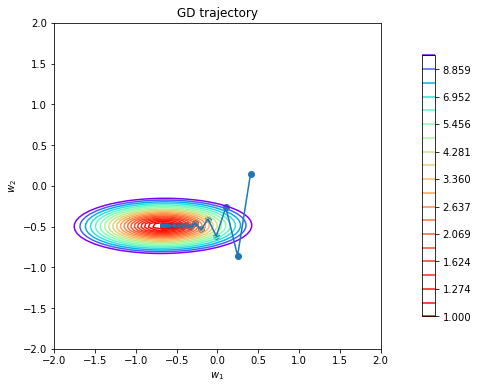

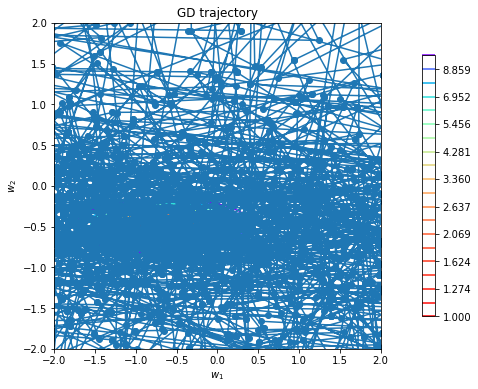

In [30]:
np.random.seed(1000)

loss = MSELoss()

w_init = np.random.uniform(-2, 2, (n_features))

w_gd = gradient_descent(w_init, X, y, loss, 0.01, 100000)
w_sa = simulated_annealing(w_init, X, y, loss, 30000, alpha=0.999)
    
plot_gd(w_gd, X, y, loss)
plot_gd(w_sa, X, y, loss)

# по-моему очевидно, что траектория градиентного спуска более стабильная